# Get started with MultiVae

In this tutorial we detail an example on how to define train and evaluate a model with MultiVae.

## Load dataset

As a simple example here (and to allow easy training), we load the MnistAttribute dataset from the library.

In [1]:
from multivae.data.datasets.mnist_labels import BinaryMnistLabels

dataset = BinaryMnistLabels('~/scratch/data', 'test',download=True)

/Users/agathe/dev/multimodal_vaes/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The modalities in that dataset are named ['images', 'labels']
The text attribute for this image is tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])


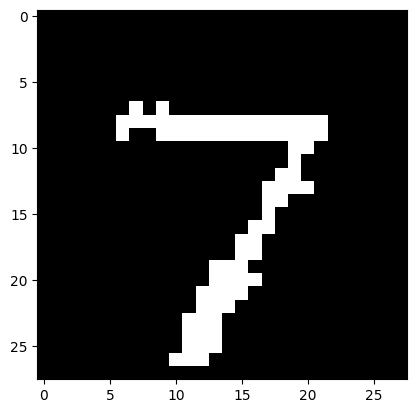

In [2]:
# visualize one sample
import matplotlib.pyplot as plt
sample = dataset[0]

# A sample contains a field 'data' with the data for both modalities (here images and labels) and eventual additional fields (labels, masks..)
print(f'The modalities in that dataset are named {list(sample.data.keys())}')

plt.imshow(sample.data['images'][0], cmap='gray')
print(f'The text attribute for this image is {sample.data["labels"]}')


## Create a model 

In [3]:
# Import the model of your choice
from multivae.models import MVTCAE, MVTCAEConfig

In [33]:
# Define the model configuration

model_config = MVTCAEConfig(
    n_modalities=2,
    latent_dim=20,
    input_dims= {'images' : (1,28,28), 'labels' : (1,10)},
    decoders_dist= {'images' : 'normal', 'labels' : 'categorical'},
    
    alpha=2./3.,
    beta=2.5,
    
    uses_likelihood_rescaling=True,
    rescale_factors=dict(images=1, labels=50)
)

In [34]:
# Initialize the model

# If no encoders/ decoders architectures are specified, default MLPs are used
model = MVTCAE(model_config = model_config)

In [35]:
# check that everything works
model(dataset[:10])

ModelOutput([('loss', tensor(551.1870, grad_fn=<DivBackward0>)),
             ('metrics',
              {'joint_divergence': tensor(21.1471, grad_fn=<MulBackward0>),
               'images': tensor(8190.6763, grad_fn=<SumBackward0>),
               'labels': tensor(0., grad_fn=<SumBackward0>),
               'kld_images': tensor(20.5024, grad_fn=<SumBackward0>),
               'kld_labels': tensor(20.0535, grad_fn=<SumBackward0>)})])

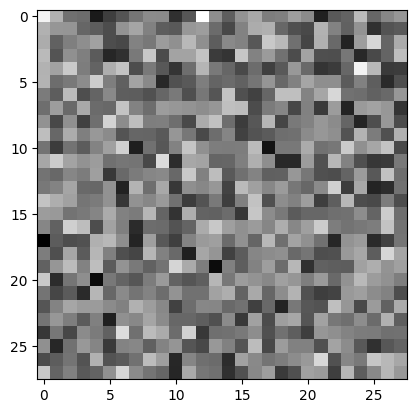

In [36]:
# Predict before training

from multivae.data import MultimodalBaseDataset
model.eval()
data = model.predict(
    inputs=MultimodalBaseDataset(data= dict(labels = dataset.labels_one_hot[0])),
    cond_mod='labels',
)


plt.imshow(data['images'][0][0], cmap='gray')

## Training

In [37]:
from multivae.trainers import BaseTrainer, BaseTrainerConfig

trainer_config = BaseTrainerConfig(
    num_epochs=20,
    learning_rate=1e-2,
    
)

trainer = BaseTrainer(
    model=model,
    training_config=trainer_config,
    train_dataset=dataset
    )

trainer.train()

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Setting the optimizer with learning rate 0.01
Created dummy_output_dir/MVTCAE_training_2023-05-27_20-32-52. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 20
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !

Training of epoch 1/20: 100%|██████████| 157/157 [00:04<00:00, 34.96batch/s]
--------------------------------------------------------------------------
Train loss: 506.6335
--------------------------------------------------------------------------
Training of epoch 2/20: 100%|██████████| 157/1

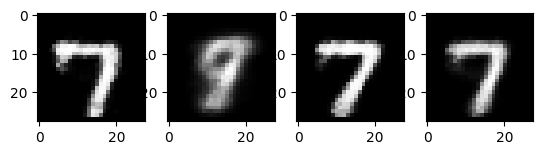

In [38]:
# Predict before training

from multivae.data import MultimodalBaseDataset

# images from label : show a few samples 
data = model.predict(
    inputs=dataset[0],
    cond_mod='labels',
    N = 4
)

fig, ax = plt.subplots(1,4)
for i in range(4):
    ax[i].imshow(data['images'][i][0][0], cmap='gray')

In [39]:
import torch
# predict labels from images 
data = model.predict(
    inputs=dataset[0],
    cond_mod='images',
    N = 4
)

for i in range(4):
    print(torch.argmax(data['labels'][i], dim=-1))
    

tensor([[2]])
tensor([[2]])
tensor([[7]])
tensor([[2]])
